In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import wave
import struct

import glob
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf

from pandas import *
from matplotlib.pyplot import specgram
from os import listdir
from os.path import isfile, join
from sklearn.metrics import precision_recall_fscore_support
%matplotlib inline

from subprocess import check_output
print(check_output(["ls", "../heartbeat"]).decode("utf8"))

artifactlog.png
artifactraw.png
artifactspec.png
extrahlslog.png
 extrahlsraw.png
extrahlsspec.png
extrasolelog.png
extrasoleraw.png
extrasolespec.png
Heartbeat Anomaly-Copy1.ipynb
Heartbeat Anomaly-Copy2.ipynb
Heartbeat Anomaly.ipynb
Heartbeat Anomaly V2.ipynb
murmurlog.png
murmurraw.png
murmurspec.png
normallog.png
normalraw.png
normalspec.png
resultsANN2.png
resultsANN3.png
resultsANN4.png
resultsANN.png
set_a
set_a.csv
set_a_timing.csv
set_b
set_b.csv



In [3]:
def load_sound_files(file_paths):
    raw_sounds = []
    for fp in file_paths:
        X,sr = librosa.load(fp)
        raw_sounds.append(X)
    return raw_sounds

def plot_waves(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        librosa.display.waveplot(np.array(f),sr=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle("Figure 1: Waveplot",x=0.5, y=0.915,fontsize=18)
    plt.show()
    
def plot_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        specgram(np.array(f), Fs=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle("Figure 2: Spectrogram",x=0.5, y=0.915,fontsize=18)
    plt.show()

def plot_log_power_specgram(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        plt.subplot(10,1,i)
        D = librosa.logamplitude(np.abs(librosa.stft(f))**2, ref_power=np.max)
        librosa.display.specshow(D,x_axis='time' ,y_axis='log')
        plt.title(n.title())
        i += 1
    plt.suptitle("Figure 3: Log power spectrogram",x=0.5, y=0.915,fontsize=18)
    plt.show()

LABELS
normal = 0
murmur = 1
extrahs = 2
artifact = 3
extrasystole = 4

In [4]:
mypath = "../heartbeat/"

seta_file = pd.read_csv('../heartbeat/set_a.csv')
setb_file = pd.read_csv('../heartbeat/set_b.csv')
df_A = DataFrame(seta_file)
df_B = DataFrame(setb_file)

# removes unlabelled data --> we're only doing supervised training for now. deal wit it.
df_A_labelled = df_A[pd.notnull(df_A['label'])] 
df_A_nulls = df_A[pd.isnull(df_A['label'])]
df_B_labelled = df_B[pd.notnull(df_B['label'])] 
df_B_nulls = df_B[pd.isnull(df_B['label'])]

# merge both sets of data
df_train = pd.concat([df_A_labelled, df_B_labelled])
df_test = pd.concat([df_A_nulls, df_B_nulls])

# training 
dflabel_train = df_train['label'].tolist() # training label includes unlabeled
dfname_train = df_train['fname'].tolist()
dflabel_test = df_test['label'].tolist() # training label includes unlabeled
dfname_test = df_test['fname'].tolist()

# creating full paths
dfname_train = [join(mypath,dfname_train[i]) for i in range(len(dfname_train))]
dfname_test = [join(mypath,dfname_test[i]) for i in range(len(dfname_test))]

dfname_train = ([s.replace('Btraining_', '') for s in dfname_train])# remove all the Btraining_s 
dfname_train = ([s.replace('set_b/extrastole_', 'set_b/extrastole__') for s in dfname_train])# remove all the Btraining_s 
dfname_train = ([s.replace('set_b/murmur_', 'set_b/murmur__') for s in dfname_train])# remove all the Btraining_s 
dfname_train = ([s.replace('set_b/murmur__n', 'set_b/murmur_n') for s in dfname_train])# remove all the Btraining_s 
dfname_train = ([s.replace('set_b/normal_', 'set_b/normal__') for s in dfname_train])# remove all the Btraining_s 
dfname_train = ([s.replace('set_b/normal__n', 'set_b/normal_n') for s in dfname_train])# remove all the Btraining_s 


In [5]:
def sound_sampler(dfname,dflabel):
    sample_name = []
    sample_label = []
    typelabels = []
    for i in range(len(dfname)):
        if dflabel[i] not in typelabels:
            typelabels = np.append(typelabels,dflabel[i])
            sample_name = np.append(sample_name,dfname[i])
            sample_label = np.append(sample_label,dflabel[i])
    return sample_name, sample_label

sound_name_sample,sound_label_sample = sound_sampler(dfname_train,dflabel_train)

In [6]:
for i in range(len(dflabel_train)):
    if dflabel_train[i]=='normal':
        dflabel_train[i]=np.int(0)
    if dflabel_train[i]=='murmur':
        dflabel_train[i]=np.int(1)
    if dflabel_train[i]=='extrahls':
        dflabel_train[i]=np.int(2)
    if dflabel_train[i]=='artifact':
        dflabel_train[i]=np.int(3)
    if dflabel_train[i]=='extrastole':
        dflabel_train[i]=np.int(4)     

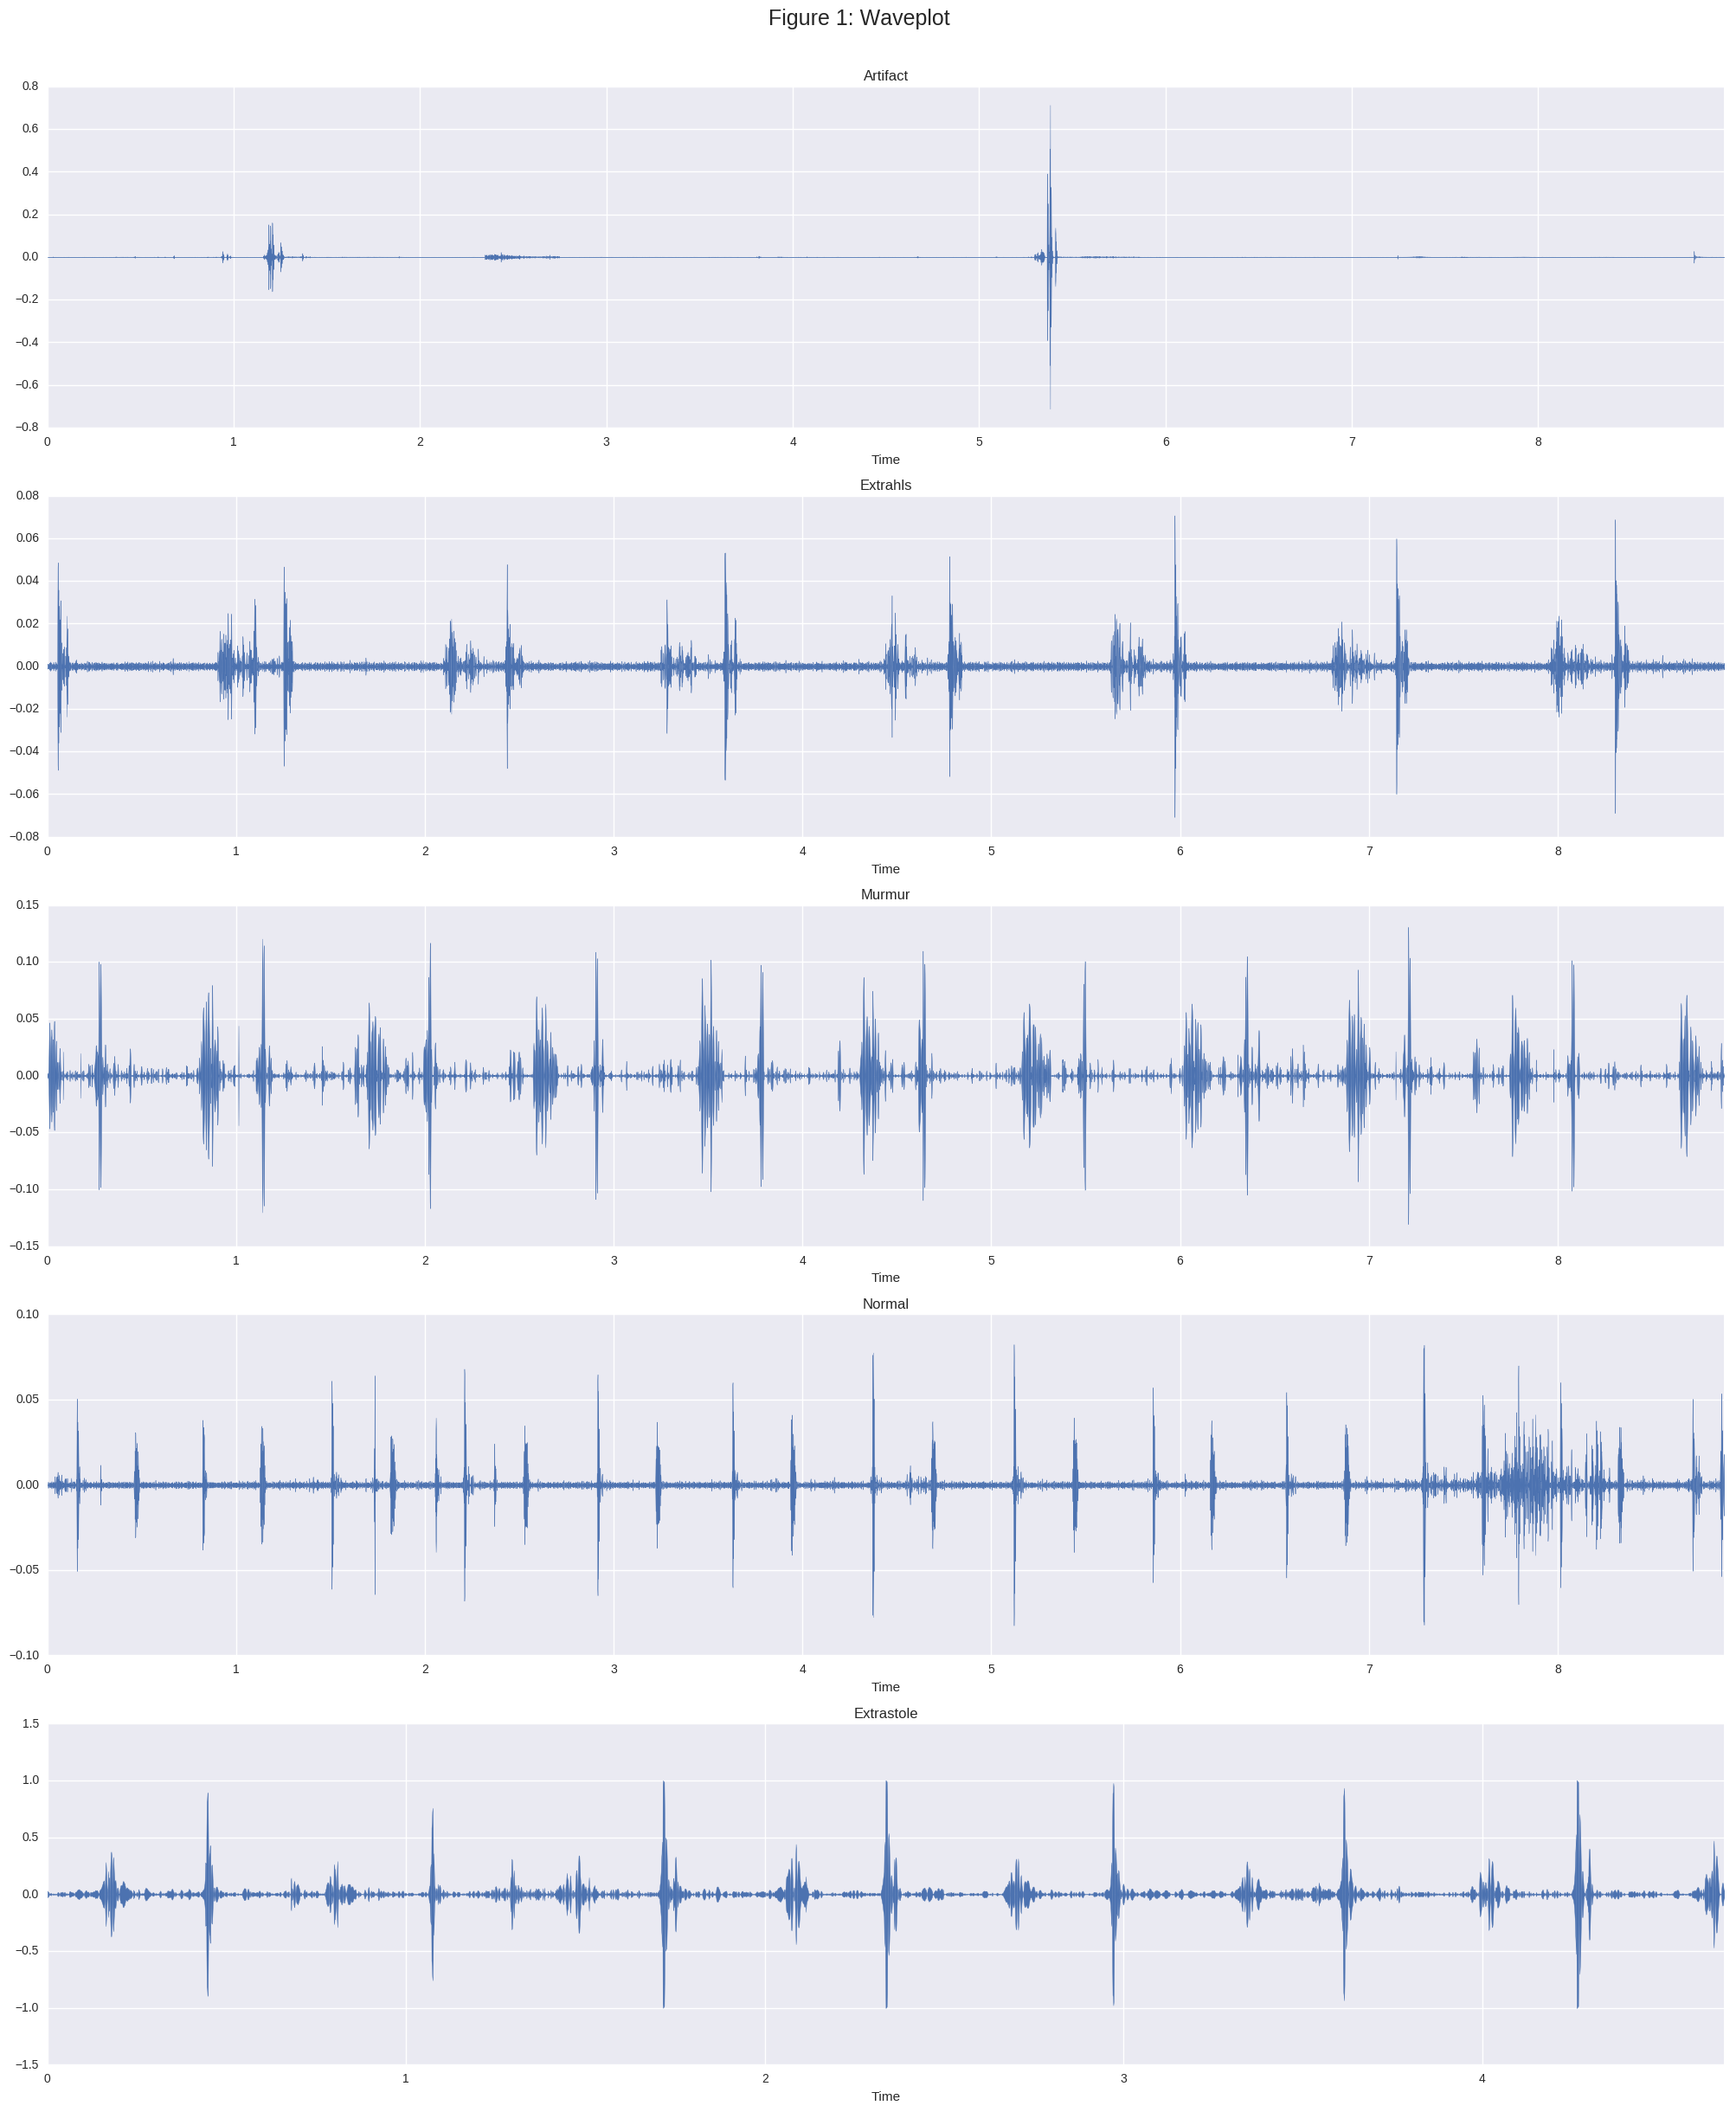

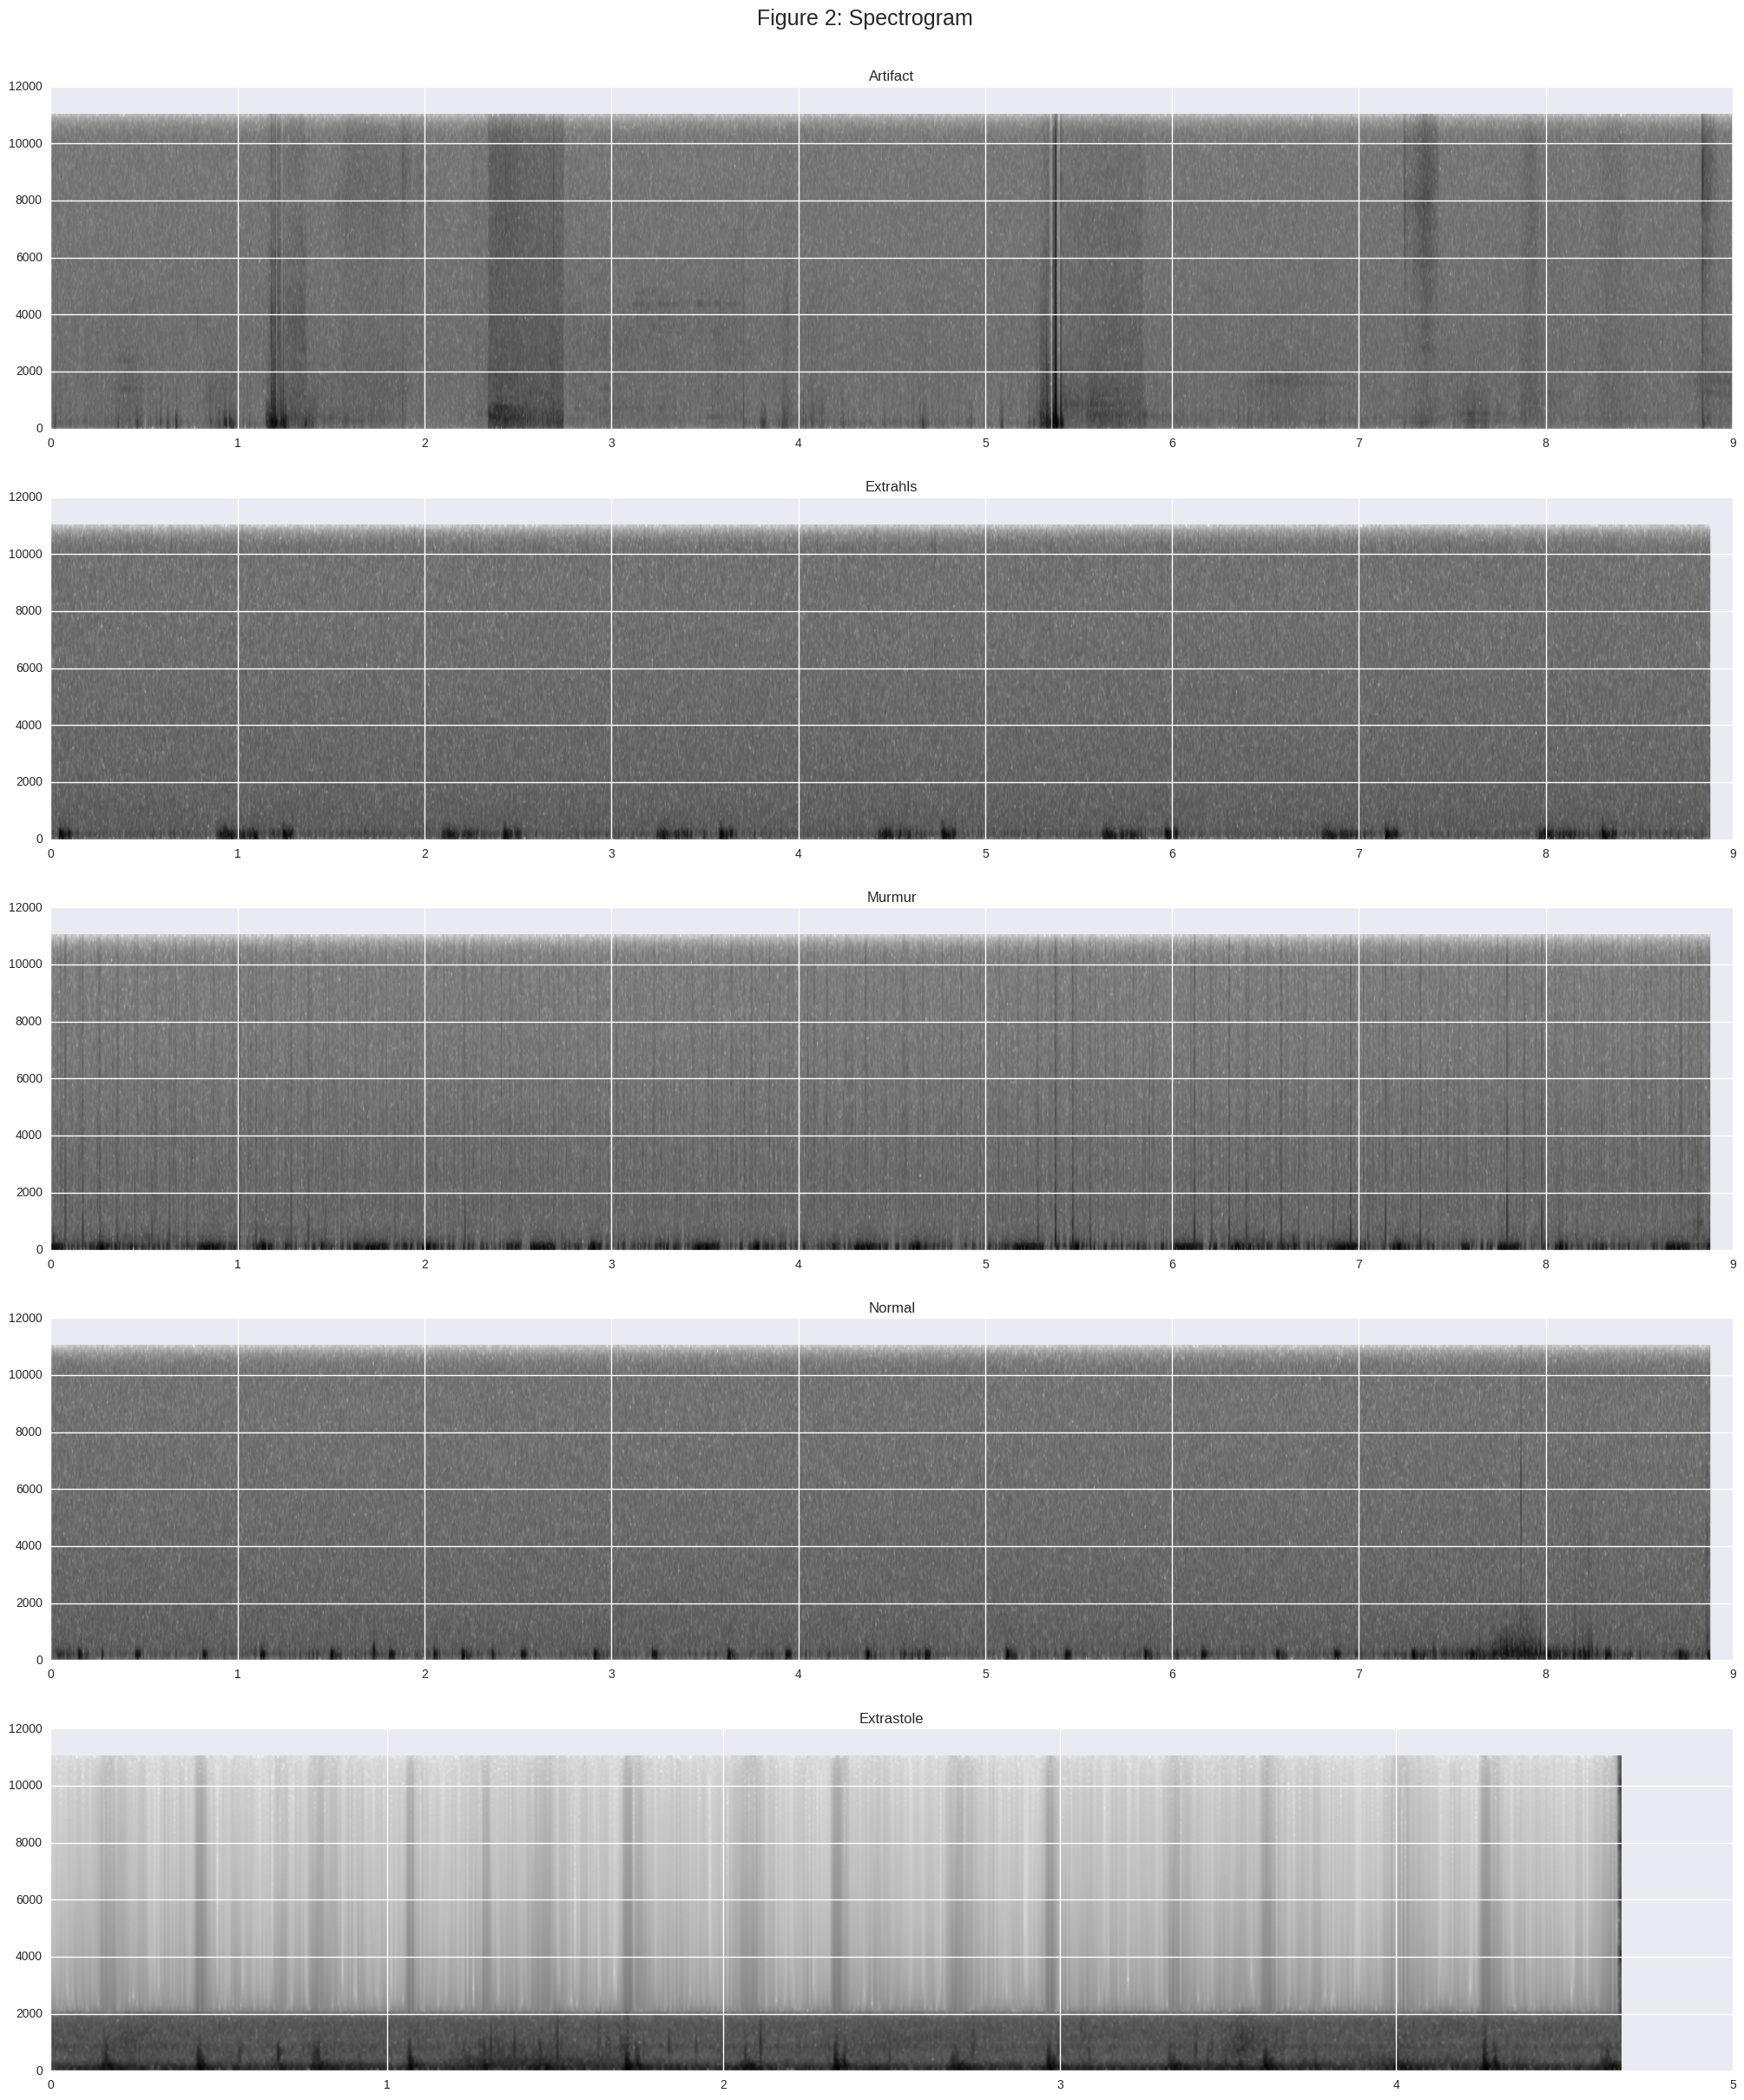

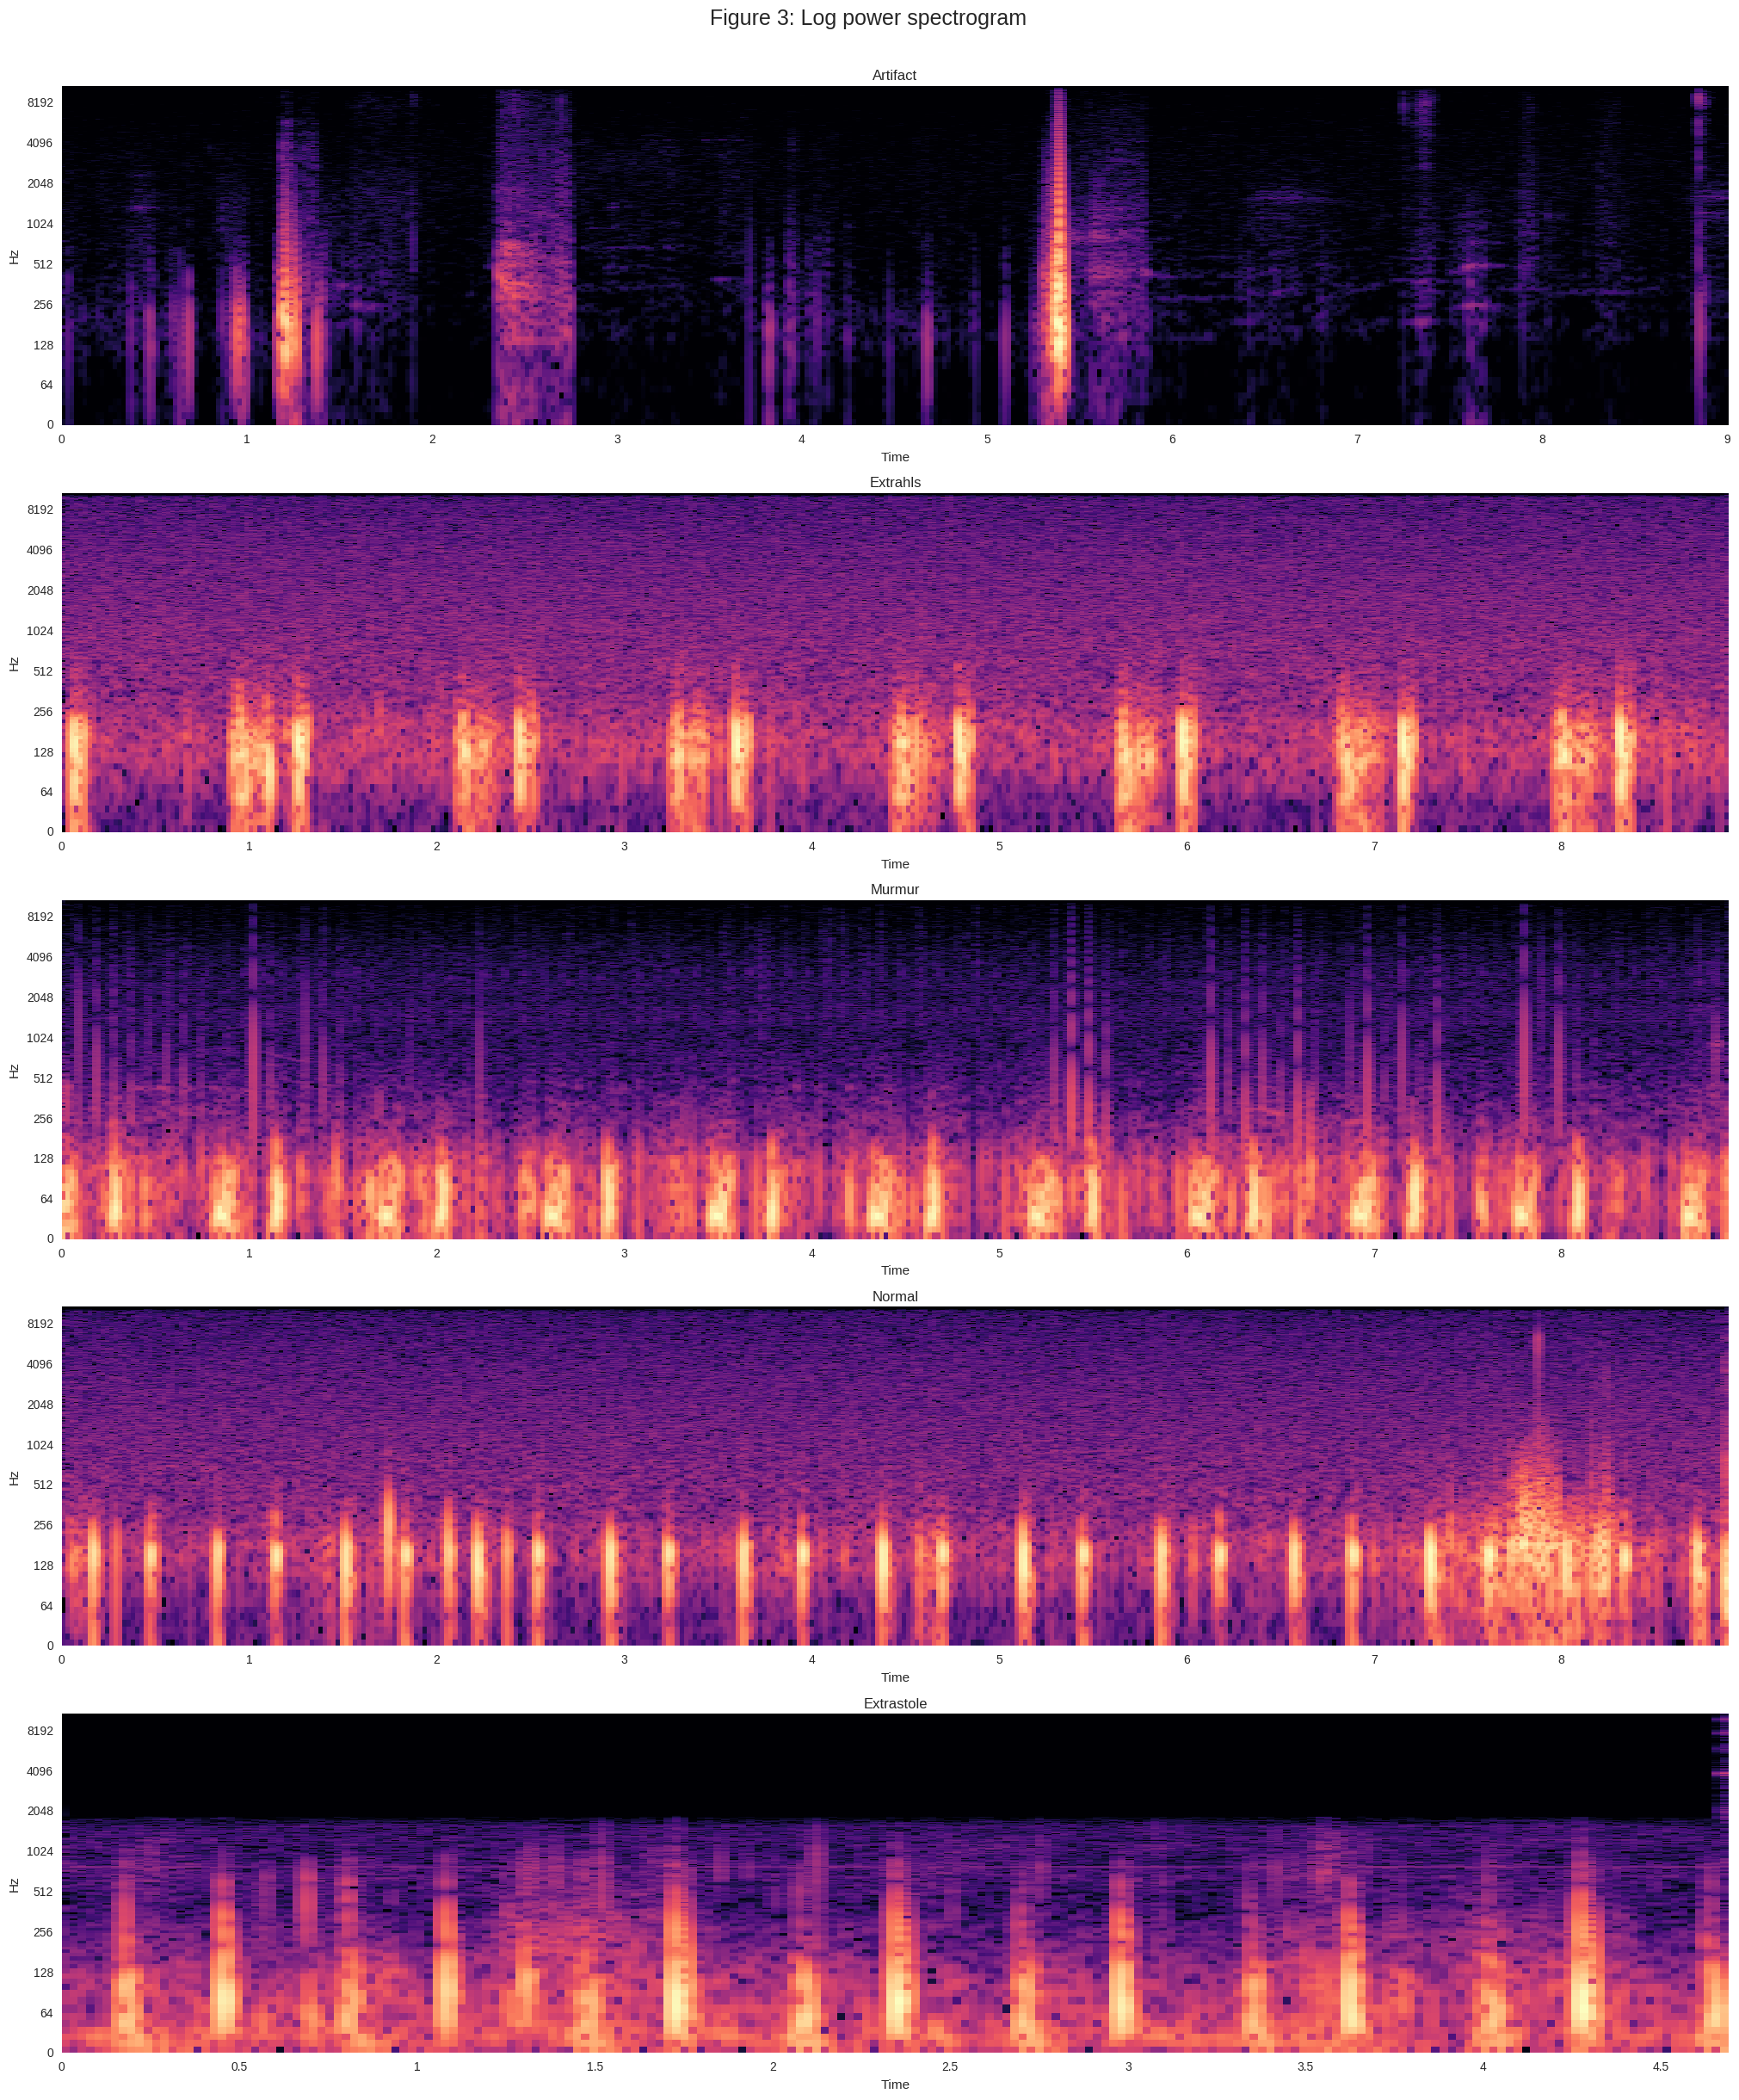

In [7]:
raw_sounds = load_sound_files(sound_name_sample)
plot_waves(sound_label_sample,raw_sounds)
plot_specgram(sound_label_sample,raw_sounds)
plot_log_power_specgram(sound_label_sample,raw_sounds)

In [8]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

def parse_audio_files(fn_name,fn_label,file_ext='*.wav'):
    features, labels = np.empty((0,193)), np.empty(0)
    ct = 0
    for fn in fn_name:
        print(ct)
        mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
        ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
        features = np.vstack([features,ext_features])
        labels = np.append(labels,fn_label[ct])
        ct = ct+1
    return np.array(features), np.array(labels, dtype = np.int)

def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [9]:
features, labels = parse_audio_files(dfname_train,dflabel_train)

# extract featuress

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


/usr/local/lib/python2.7/dist-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
2

In [10]:
labels = one_hot_encode(dflabel_train)
# labels = one_hot_encode(labels)

train_test_split = np.random.rand(len(features)) < 0.70
train_x = features[train_test_split]
train_y = labels[train_test_split]
test_x = features[~train_test_split]
test_y = labels[~train_test_split]

train_x

array([[ -5.94025607e+02,   3.87705564e+01,   5.47149875e+00, ...,
          3.44868961e-03,   1.05748262e-03,  -3.52783070e-03],
       [ -7.51323926e+02,   3.03907595e+01,  -5.21725864e+00, ...,
          7.11115832e-04,  -4.64519989e-04,   1.67710652e-04],
       [ -5.59913139e+02,   3.62597985e+01,  -1.40334634e+01, ...,
         -1.44128250e-03,   1.19377352e-03,  -9.26784677e-04],
       ..., 
       [ -4.56566267e+02,   1.73335577e+02,   3.78196530e+01, ...,
          4.93734718e-02,   1.19458211e-02,   1.27708400e-02],
       [ -3.42085255e+02,   1.94474637e+02,   5.55083973e+01, ...,
          1.49669357e-02,   4.38641415e-03,   9.07185238e-03],
       [ -3.68191906e+02,   2.08697238e+02,   6.63912168e+01, ...,
          5.76617639e-03,   3.03437189e-03,   4.43141250e-03]])

In [111]:
training_epochs = 5000
n_dim = features.shape[1]
n_classes = 5
n_hidden_units_one = 400 
n_hidden_units_two = 500
sd = 1 / np.sqrt(n_dim)
#learning_rate = 0.005
#learning_rate = 0.002
learning_rate = 0.005

In [112]:
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.tanh(tf.matmul(X,W_1) + b_1)


W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)


W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)

init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [113]:
cost_function = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(y_), reduction_indices=[1])) 
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [114]:
cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:train_x,Y:train_y})
        cost_history = np.append(cost_history,cost)
    
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: test_x})
    y_true = sess.run(tf.argmax(test_y,1))

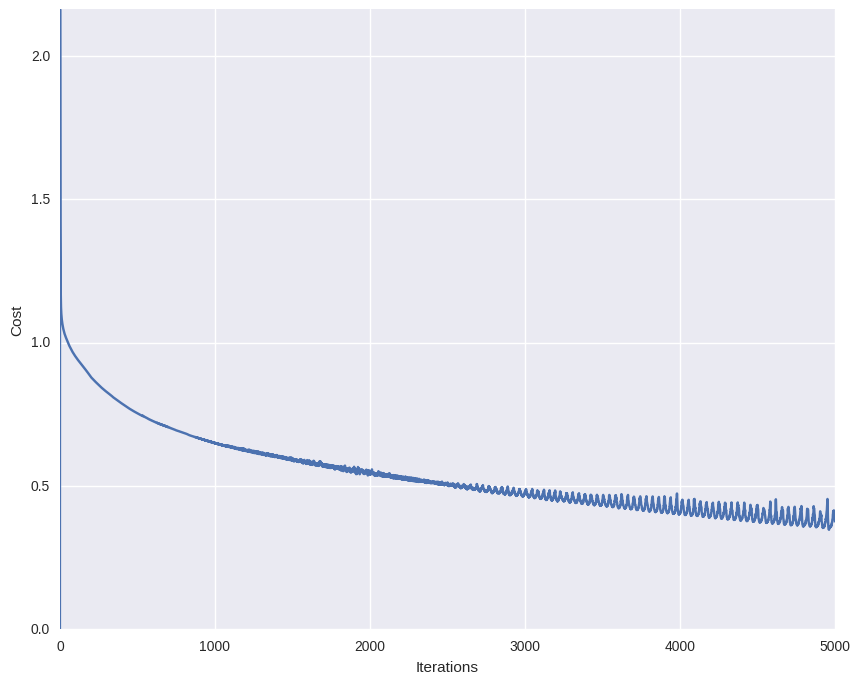

F-Score: 0.722


In [115]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print "F-Score:", round(f,3)

In [116]:
from sklearn import metrics
print(metrics.classification_report(y_true,y_pred))

             precision    recall  f1-score   support

          0       0.75      0.85      0.80        96
          1       0.63      0.50      0.56        38
          2       0.60      1.00      0.75         3
          3       0.93      0.87      0.90        15
          4       0.00      0.00      0.00        10

avg / total       0.69      0.72      0.70       162

